In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pingouin as pg

## Warsaw real estate market analysis

* [Dataset overwiew](#Dataset-overwiew)
* [Price influencing factors](#Price-influencing-factors)
* [Śródmieście analysis](#Śródmieście-analysis)
* [Price model](#Price-model)
* [Summary](#Summary)

This my biggest data science project so far. I've been working on it during my university summer break. As the title say it's about Warsaw real estate market. I started it by scrapping data from estates auction site named **otodomo**. For this purpose I wrote my own script using **Beautifulsoup** and **Request** libraries. Dataset consist offerts from June 2022. At the begging it had 23323 rows and 14 columns but since the offerts were badly described and misssing lots of rows. Therefore during data cleaning I made decission to drop every row missing at least one value. After cleaning I was left with 5930 rows. More details about data processing and exploration I will describe in later paragraphs.

My main questions about data are:
- What are the most important factors influencing price of real estate?
- Which and why specific districts are more expensive?
- What are the differes between most expensive and cheapest districts?
- How well can I predict price of real estate?

Before that let's explore the dataset.

### Dataset overwiew

Like i mentioned following data is already cleaned and ready to use. Therefore we will already start with some basic statistics. Howerver I want to aknoledge that since I dropped almost quater of the data it might not be the best representation of the market. So let's keep that in mind.

In [3]:
data = pd.read_csv('data/data_clean_removed.csv',usecols= 
['district','Price', 'Space','Rooms','Market','Year','elevator','Parking place','balkon','taras','ogródek','district','street','level','max_level'])

data['district'] =data['district'].str.replace(" ","")
data['Year'] = data['Year'].astype(str) 
data['Price'] = data['Price'].astype(float)
data['Space'] = data['Space'].astype(float)

In [4]:
data.head()

,Price,Space,Rooms,Market,Year,elevator,Parking place,balkon,taras,ogródek,district,street,level,max_level
0,4000000.0,560.0,4,wtórny,2015,1,1,1,1,1,Wawer,Patriotów,3,3
1,4000000.0,560.0,4,wtórny,2015,1,1,1,1,1,Wawer,Patriotów,3,3
2,21350100.0,487.0,10,wtórny,2021,1,1,0,0,0,Śródmieście,Elektryczna,6,6
3,19900000.0,487.0,6,wtórny,2001,1,1,0,0,0,Mokotów,Cybulskiego,5,5
4,795900.0,445.0,2,pierwotny,2022,1,1,0,0,0,Praga-Południe,Gocław,4,8


In [5]:
print(f'Final dataset shape: number of rows {data.shape[0]}, number of columns {data.shape[1]}')

Final dataset shape: number of rows 5930, number of columns 14


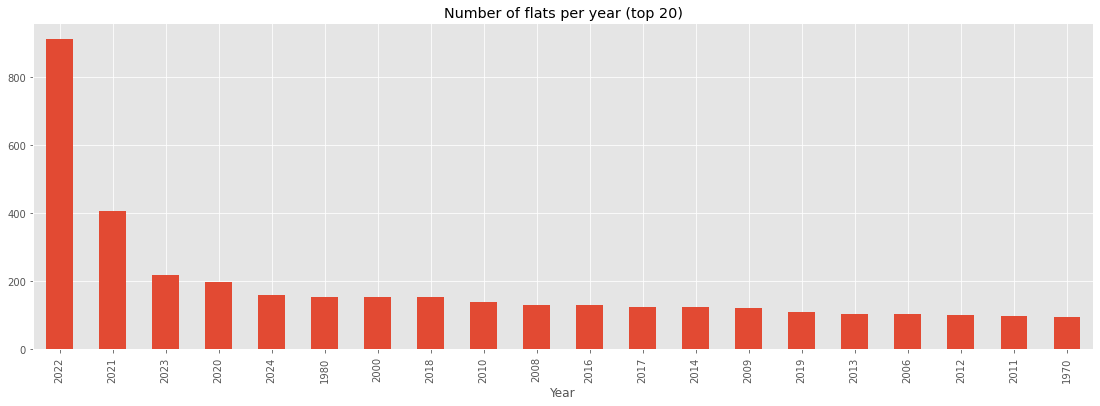

In [6]:
plt.style.use('ggplot')

data.groupby('Year')['Price'].agg(len).sort_values(ascending=False)[:20].plot(kind='bar',figsize=(19,6),title='Number of flats per year (top 20)');

Most flats are newly build. Flats from the past 4 years and 2024 being under construction right now are in top 5 of the most flats annual.

In [7]:
new = len(data[data['Year'] == '2022']) + len(data[data['Year'] == '2021']) + len(data[data['Year'] == '2023']) + len(data[data['Year'] == '2020']) +len(data[data['Year'] == '2024'])
new / len(data) 

0.3198988195615514

Combined fresh estates make almost 32% of the whole dataset. It's not a big surprise since Warsaw is still growing and there is a lot of new estates being built.

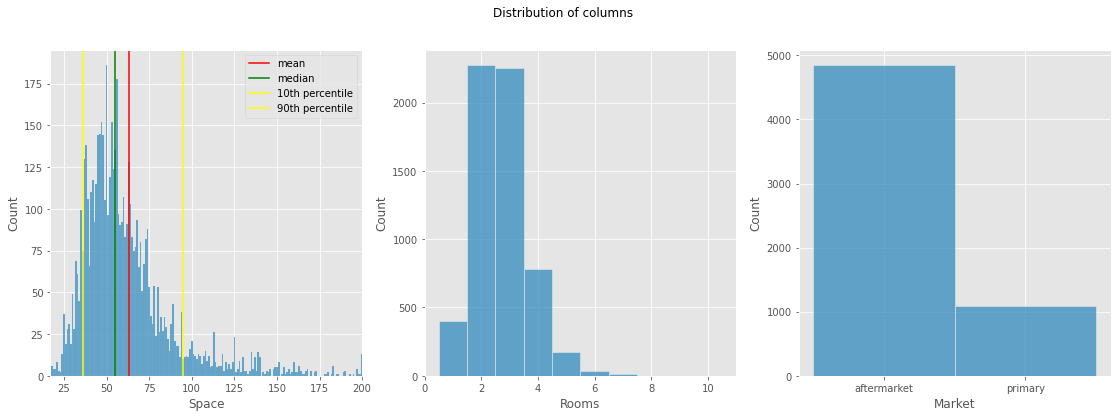

In [8]:
fig, ax = plt.subplots(1,3,figsize=(19,6))
fig.suptitle('Distribution of columns')

ax[0].axline((np.mean(data['Space']),0),(np.mean(data['Space']),100),color='red',label='mean')
ax[0].axline((np.median(data['Space']),0),(np.median(data['Space']),100),color='green',label='median')
ax[0].axline((np.percentile(data['Space'], 10),0),(np.percentile(data['Space'], 10),100),color='yellow',label='10th percentile')
ax[0].axline((np.percentile(data['Space'], 90),0),(np.percentile(data['Space'], 90),100),color='yellow',label='90th percentile')
ax[0].legend()
sns.histplot(data, x ='Space', discrete=True, ax = ax[0])
ax[0].set_xlim(np.min(data.Space),200);

sns.histplot(data, x ='Rooms', discrete=True, ax = ax[1])
sns.histplot(data, x ='Market', discrete=True, ax = ax[2])
ax[2].set_xticks(['wtórny','pierwotny'],['aftermarket','primary']);


In [9]:
np.mean(data['Space']), np.median(data['Space']), np.percentile(data['Space'], 10), np.percentile(data['Space'], 90)

(63.23962900505902, 55.0, 36.0, 95.0)

Mean **space** of the estates in Warsaw is 64.5 m2. Median is 55 m2, the 10th percentile is 36m2 and 90th percentile is 95m2. So the most of data is bettwen 36 and 95m2.

Most common are apartments with two to four **rooms**. Below you cans see the distribution of Space in the apartemnts with the respective number of rooms.

In [10]:
data.groupby('Rooms')['Space'].agg([np.mean, np.median])

,mean,median
Rooms,,
1,30.611940,31.0
2,45.940633,45.0
3,65.616851,63.0
4,97.300385,89.0
5,142.381503,130.0
6,197.617647,175.0
7,201.090909,218.0
10,455.000000,455.0


Apartments in move-in condition account for 18% of the dataset.

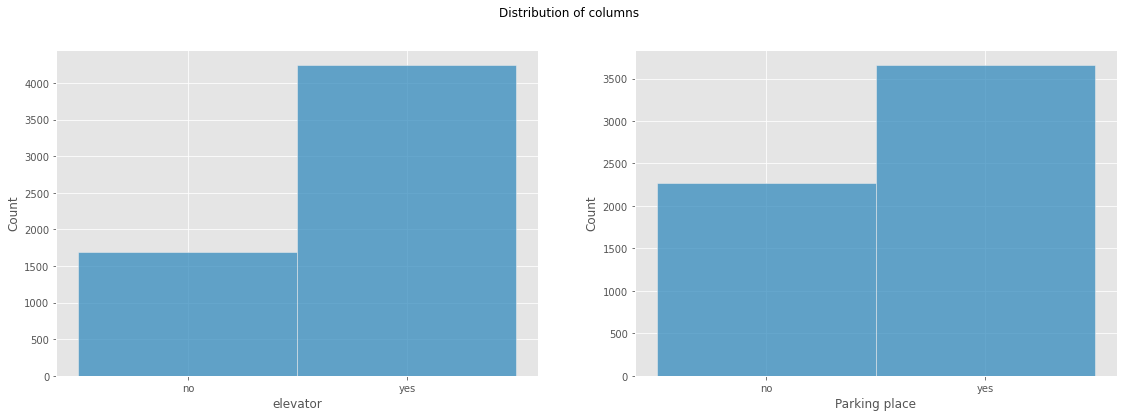

In [11]:
fig, ax = plt.subplots(1,2,figsize=(19,6))
fig.suptitle('Distribution of columns')

plt.xticks([0,1]);
sns.histplot(data, x ='elevator', discrete=True, ax = ax[0]);
ax[0].set_xticks([0,1],['no','yes']);

sns.histplot(data, x ='Parking place', discrete=True, ax = ax[1]);
ax[1].set_xticks([0,1],['no','yes']);


The above plots shows that elevators and parking spaces are frequent feature inside apartment block.

In [12]:
print('Elevator is found in  72% of the tenants')

Elevator is found in  72% of the tenants


In [13]:
print('Parking place is found in  61% of the tenants')

Parking place is found in  61% of the tenants


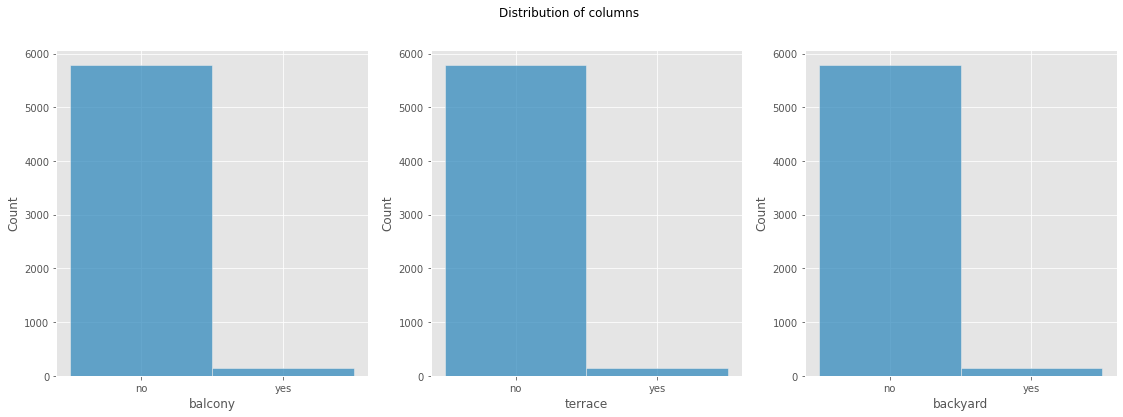

In [14]:
fig, ax = plt.subplots(1,3,figsize=(19,6))
fig.suptitle('Distribution of columns')

plt.xticks([0,1]);
sns.histplot(data, x ='balkon', discrete=True, ax = ax[0]);
ax[0].set_xlabel('balcony')
ax[0].set_xticks([0,1],['no','yes']);

sns.histplot(data, x ='taras', discrete=True, ax = ax[1]);
ax[1].set_xlabel('terrace')
ax[1].set_xticks([0,1],['no','yes']);

sns.histplot(data, x ='ogródek', discrete=True, ax = ax[2]);
ax[2].set_xlabel('backyard')
ax[2].set_xticks([0,1],['no','yes']);


As you can see most apartments lacks any kind of outside space. Below 10% of the estates have balcony or terrace or backyard. 

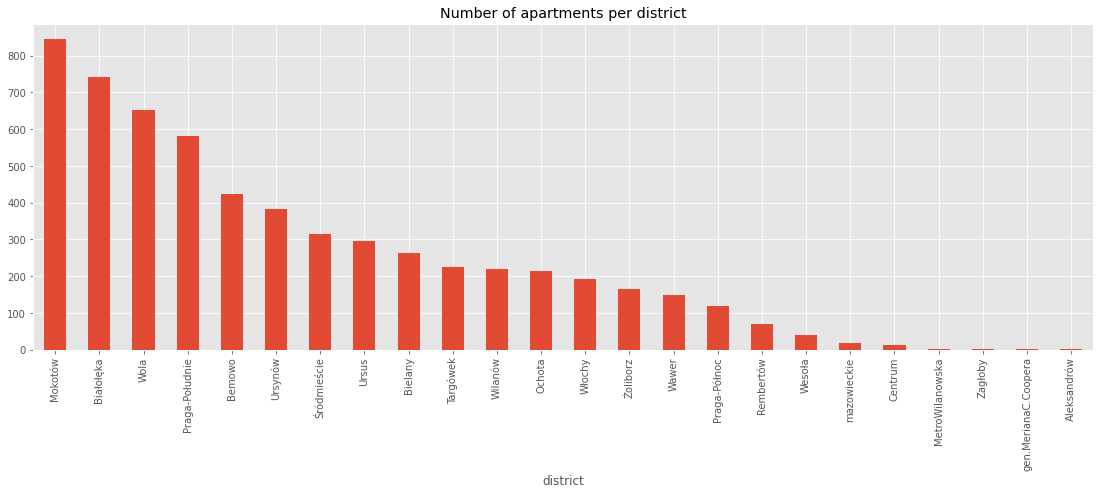

In [15]:
data.groupby('district')['Price'].agg(len).sort_values(ascending=False).plot(kind='bar',figsize=(19,6),title='Number of apartments per district');

Most of the avaible estates are located on left bank of the Vistula river. Altough **Białołęka** and **Praga-Południe** which are on the rigth side contribute in noticeable way.

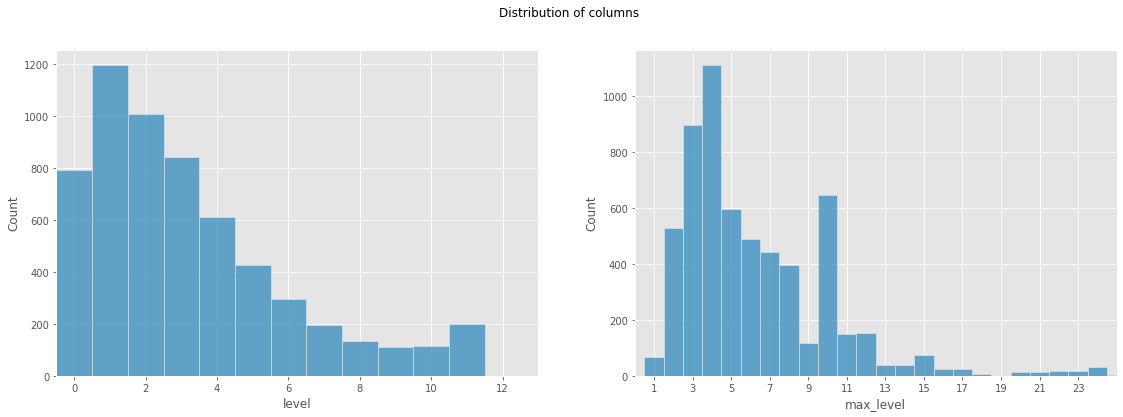

In [16]:
fig, ax = plt.subplots(1,2,figsize=(19,6))
fig.suptitle('Distribution of columns')


sns.histplot(data, x ='level', discrete=True, ax = ax[0])
ax[0].set_xlim(-0.5,13);

sns.histplot(data, x ='max_level', discrete=True, ax = ax[1])
ax[1].set_xlim(0,25);
plt.xticks(np.arange(np.min(data['max_level']), 25, 2.0));

In [24]:
len(data[data['level'] <8]) / len(data), len(data[data['max_level'] <11]) / len(data)

(0.9052276559865092, 0.8924114671163575)

90 percent of the estates are on the level 7 or lower. Nearly 90 percent if the blocks of flats are 10 or less stories high. 

In [15]:
print(f"Mean price of a apartment is { round(np.mean(data['Price']),2) } PLN, median of a price is {round(np.median(data['Price']),2)} PLN, 10th percentile is equal to \
{round(np.percentile(data['Price'], 10),2)} PLN and 90th percentile is {round(np.percentile(data['Price'], 90),1)} PLN.")

Mean price of a apartment is 912884.13 PLN, median of a price is 699000.0 PLN, 10th percentile is equal to 465000.0 PLN and 90th percentile is 1485500.0 PLN.


In [31]:
data.groupby('district')['Price'].agg([np.mean, np.median]).sort_values(by='mean',ascending=False)[:5]

,mean,median
district,,
Śródmieście,1.776443e+06,1100000.0
Mokotów,1.288718e+06,875000.0
Centrum,1.267892e+06,1460000.0
Wilanów,1.117413e+06,940000.0
Żoliborz,1.097245e+06,885000.0


**Mokotów** is a very interesting district it has the most avaible estates but also the most expensive ones.

In [33]:
data.groupby('district')['Price'].agg([np.mean, np.median]).sort_values(by='mean',ascending=False)[-5:]

,mean,median
district,,
Zagłoby,617000.000000,617000.0
Ursus,616413.732203,594867.0
Białołęka,591461.878706,562455.0
Aleksandrów,556000.000000,556000.0
Rembertów,529693.420290,511801.0


 **Rembertów** is the cheapest district with the least number of estates.

### Śródmieście analysis

### Price model

I have created my model using python automl library called **pycaret** (https://pycaret.org). 

In [6]:
from pycaret.regression import *
setup = setup(data, target = 'Price',fold_shuffle=True,imputation_type='iterative')

,Description,Value
0,Session id,4272
1,Target,Price
2,Target type,Regression
3,Data shape,"(7710, 14)"
4,Train data shape,"(4150, 14)"
5,Test data shape,"(3560, 14)"
6,Ordinal features,1
7,Numeric features,9
8,Categorical features,4
9,Preprocess,True


Above you can see settings I have used model during model training.

For the further exploration I decide to use Extra Trees Regressor, Gradient Boosting Regressor and Random Forest Regressor. I have chosen them because they are the most accurate models.

In [7]:
three_best = compare_models(n_select = 2,include =['rf','et','gbr'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,136474.5769,218114843849.5722,434721.4897,0.7618,0.1825,0.1285,0.2890
gbr,Gradient Boosting Regressor,150250.6824,252277765035.2692,466234.8836,0.7311,0.1883,0.1405,0.1750
rf,Random Forest Regressor,158785.9025,252448111100.9207,468402.1640,0.7256,0.2030,0.1562,1.0630


In [14]:
best = compare_models(n_select = 1,include =['et'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,136474.5769,218114843849.5722,434721.4897,0.7618,0.1825,0.1285,0.2280


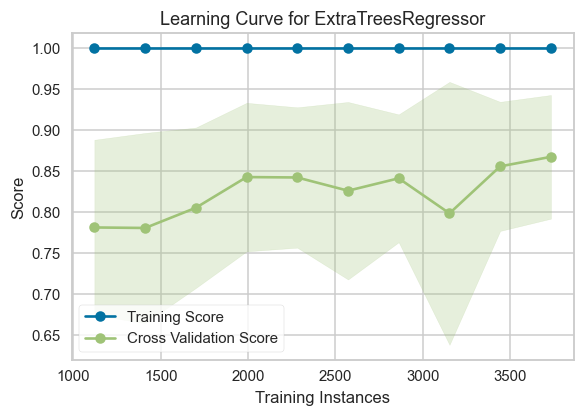

In [13]:
plot_model(best, plot = 'learning', scale=1.5)

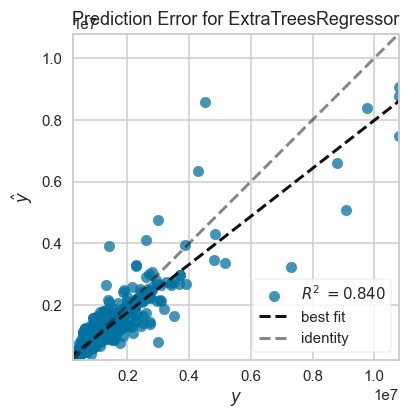

In [16]:
plot_model(best, plot = 'error', scale=1.5)

Model score is 0.85. It's not the best score but it's not bad either. I think that it's good enough to serve as a baseline model for inference purposes.

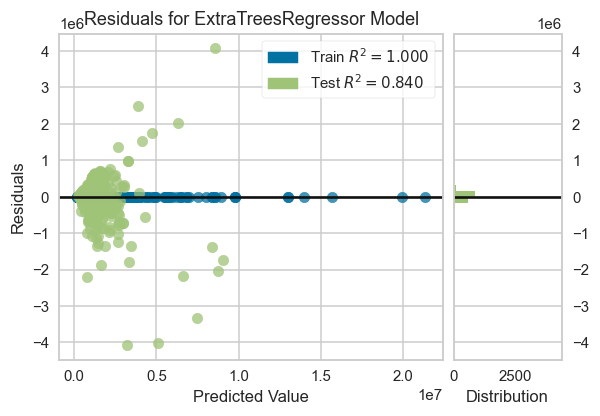

In [17]:
plot_model(best, plot ='residuals', scale=1.5)

Train R^2 equal 1 might be the indicator of overfitting of the algorithm. Nevertheles I have decided to use it because it's the most accurate model.

### Price influencing factors

In [29]:
data.corr()['Price']

Price            1.000000
Space            0.772794
Rooms            0.485594
elevator         0.090215
Parking place    0.139895
balkon           0.016927
taras            0.016927
ogródek          0.016927
level            0.074093
max_level        0.014316
Name: Price, dtype: float64

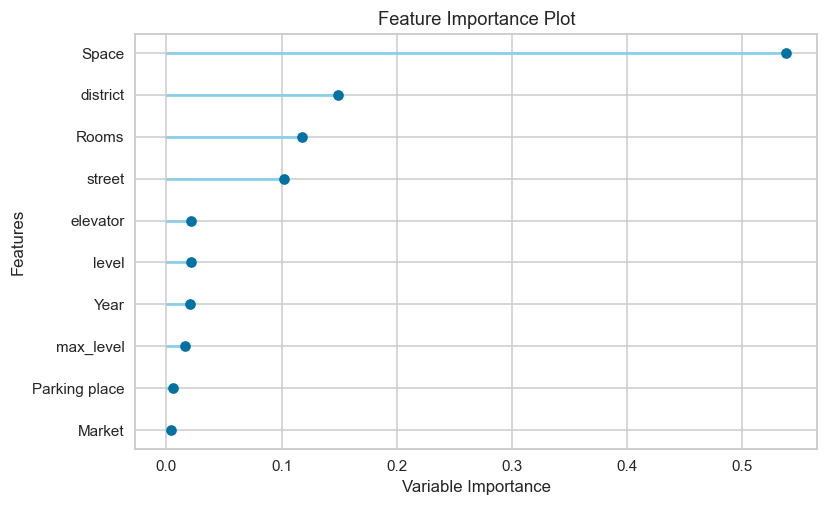

In [20]:
plot_model(best, plot = 'feature',scale=1.1)

Not suprising that **space** is the most important factor influencing price of the estate. It's followed by **districts** and number of **Rooms**. **Street** is another important factor howerver it might be highly correlated with district and therefore it's delivering same information to the model.

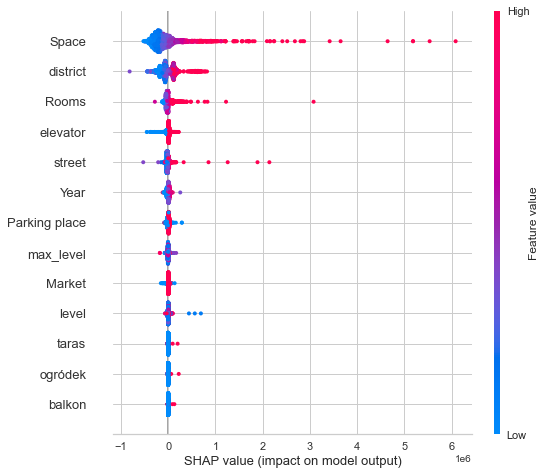

In [29]:
interpret_model(best)

SHAP values confirms previous conclusions.

### Summary